# Тетрадка с анализом прогнозов моделей photo-z для Тихоновских Чтений 2022


### 0. Конвертация csv в pkl, чтобы можно было подпихнуть моему скрипту
**Важно** эту часть нужно выполнять под версиями библиоткек `python==3.7.5 pandas==1.3.0`

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

WORKDIR = Path("./data/")
CSV_SAMPLE = WORKDIR / "triton_20221004-164314.csv"
PKL_SAMPLE = WORKDIR / "triton_20221004-164314.pkl"

In [ ]:
data = pd.read_csv(CSV_SAMPLE)

assert data["RA"].dtype == np.float64
assert data["RA"].isna().sum() == 0
assert data["Dec"].dtype == np.float64
assert data["Dec"].isna().sum() == 0
assert len(data.index) == len(data.index.unique())

data.to_pickle(PKL_SAMPLE, protocol=4)

In [ ]:
!nice -20 python3 /data/SRGz/pzph1/pzph1dot1.py --outputDir ./x1a --baseCatalog ls \
    --xrayCatalog triton_20221004-164314.pkl --primaryRadius=1 \
    --xrayRaCol RA --xrayDecCol Dec \
    --baseRaCol ra --baseDecCol dec \
    --njobs 18 --chunkSize 99999 \
    --modelsSeries x1a --modelsIds 18 19 21 22 34 35

!nice -20 python3 /data/SRGz/pzph1/pzph1dot1.py --outputDir ./gal0 --baseCatalog ls \
    --xrayCatalog triton_20221004-164314.pkl --primaryRadius=1 \
    --xrayRaCol RA --xrayDecCol Dec \
    --baseRaCol ra --baseDecCol dec \
    --njobs 18 --chunkSize 99999 \
    --modelsSeries gal0 --modelsIds 19 21 22 35


### 1. Чтение прогнозов

In [1]:
import os
from pathlib import Path
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

WORKDIR = Path("./data/")
CSV_SAMPLE = WORKDIR / "triton_20221004-164314.csv"
X1A_RESULTS = WORKDIR / "x1a"
GAL0_RESULTS = WORKDIR / "gal0"

IMGS_PATH = WORKDIR / "imgs"
os.makedirs(IMGS_PATH, exist_ok=True)

np.set_printoptions(precision=3)
sns.set('talk', 'whitegrid', 'deep', font_scale=1.0,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
pd.set_option('display.max_rows', 400, 'display.max_columns', None, 'display.max_colwidth', 100)
plt.rcParams.update({'font.size': 24})
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def clean_data(data: pd.DataFrame):
    def ugly_object_to_beautiful_float(value: str or float) -> float:
        if isinstance(value, float):
            return value

        if "," in value:
            value = value.replace(",", ".")

        return float(value)

    def negative_to_nan(value: float) -> float:
        if value < 0:
            return np.nan

        return value

    assert "Redshift_str" in data.columns
    data.loc[:, "Redshift_str"] = (
        data.loc[:, "Redshift_str"]
            .map(ugly_object_to_beautiful_float)
            .replace(-1.0, -999.0).astype(float)
            .map(negative_to_nan)
    )
    return data


def read_predictions(path: Path, other_path: Path, n_chunks=1) -> pd.DataFrame:
    model_series = path.name
    other_model_series = other_path.name
    return pd.concat([
        pd.concat([
            pd.read_pickle(path / f"part-{i:05d}.features.gz_pkl", compression='gzip'),
            pd.read_pickle(path / f"part-{i:05d}.predictions.{model_series}.gz_pkl", compression='gzip'),
            pd.read_pickle(path / f"part-{i:05d}.best.{model_series}.gz_pkl", compression='gzip'),
            pd.read_pickle(other_path / f"part-{i:05d}.best.{other_model_series}.gz_pkl", compression='gzip'),
            pd.read_pickle(other_path / f"part-{i:05d}.predictions.{other_model_series}.gz_pkl", compression='gzip'),
        ], axis=1)  # DO NOT FORGET AXIS=1 WHEN JOINING FEATURES, PREDICTIONS AND BEST FILES
        for i in range(n_chunks)
    ])

filter_query = (
    "Status == 'Сделано' "
    "and Prog in ('eXVAR', 'FDS4', 'eXVAGN3', 'TDEs2', 'TDEs4', 'QPE', 'TDEs2r7', 'TDEs5') "
    "and Redshift_str > 0"
)
orig_sample = clean_data(pd.read_csv(CSV_SAMPLE)).query(filter_query)
train_objids = pd.read_csv(WORKDIR / "train_objids.csv")
gal0_data = x1a_data = clean_data(read_predictions(X1A_RESULTS, GAL0_RESULTS)).query(filter_query)

orig_sample.shape[0], x1a_data.shape[0], gal0_data.shape[0]

(312, 312, 312)

In [3]:
mask = gal0_data["sdss_objID"].notna()
objids = gal0_data.loc[:, 'sdss_objID']
result = pd.Series(False, index=objids.index) # objids.copy()
result.loc[mask] = objids.loc[mask].astype(int).isin(train_objids["objID"])
result.sum()

x1a_data = x1a_data.loc[~result]
gal0_data = gal0_data.loc[~result]

orig_sample.shape[0], x1a_data.shape[0], gal0_data.shape[0]

(312, 289, 289)

In [4]:
def add_colorbar(fig, vmin, vmax, label='', cmap='magma', bar_width=0.05):
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.05, bar_width, 0.9])
    cbar_ax.set_title(label)
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)


def scatter_photo_z(data, col_true, col_pred, col_conf=None,
                    xlim=None, ylim=None, figsize_factor=1, xticks=11, yticks=11,
                    cmap='rainbow', title='', marker='o', alpha=1, ax=None, s=None,
                    outliers_area=0.15):

    if xlim and ylim:
        x_border_size = (xlim[1] - xlim[0]) / 25
        y_border_size = (ylim[1] - ylim[0]) / 25
        xlim_w_borders = (xlim[0] - x_border_size, xlim[1] + x_border_size)
        ylim_w_borders = (ylim[0] - y_border_size, ylim[1] + y_border_size)
        figsize = ((xlim_w_borders[1]-xlim_w_borders[0])*figsize_factor,
                   (ylim_w_borders[1]-ylim_w_borders[0])*figsize_factor)
    else:
        xlim_w_borders = None
        ylim_w_borders = None
        figsize = (10,10)



    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax_given = False
    else:
        ax_given = True

    ax.set(
        title=title,
        xticks=np.linspace(*xlim, xticks),
        yticks=np.linspace(*ylim, yticks),
        xlim=xlim_w_borders,
        ylim=ylim_w_borders,
    )
    ax.tick_params(axis='x', rotation=90)
    if not ax_given:
        ax.set(xlabel='$z_{spec}$', ylabel='$z_{phot}$')

    if col_conf is not None:
        ax.scatter(
            data[col_true], data[col_pred],
            c=data[col_conf].astype(float),
            s=50*data[col_conf].astype(float)**(3/2)*figsize_factor if s is None else s,
            cmap=cmap, marker=marker, vmin=0, vmax=1
        )
    else:
        ax.scatter(
            data[col_true], data[col_pred],
            cmap=cmap, marker=marker, vmin=0, vmax=1, alpha=alpha, s=s, color='black'
        )


    #     ax.fill_between([0,99], [-0.15, 84], [0.15,114], color='black', alpha=0.05)
    #     ax.plot([0,99], [-0.15, 84], c='black', linestyle=':')
    #     ax.plot([0,99], [0.15,114], c='black', linestyle=':')
    #     ax.plot([0,7],[0,7], c='black', linestyle='--')

    y1, y2 = -outliers_area, -outliers_area + (1 - outliers_area) * 99
    y3, y4 = +outliers_area, +outliers_area + (1 + outliers_area) * 99
    ax.fill_between([0,99], [y1, y2], [y3, y4], color='black', alpha=0.05)
    ax.plot([0,99], [-outliers_area, -outliers_area + (1 - outliers_area) * 99], c='black', linestyle=':')
    ax.plot([0,99], [+outliers_area, +outliers_area + (1 + outliers_area) * 99], c='black', linestyle=':')
    ax.plot([0,7],[0,7], c='black', linestyle='--')

    ax.grid(linestyle='--')


def nmad_z(z_pred: np.ndarray, z_true: np.ndarray) -> float:
    """
    Calculates NMAD error using dz_norm = (z_pred - z_true)/(1 + z_true) instead of dz = (z_pred - z_true)
    :param z_pred: numpy.ndarray, shape = (number of objects), values of predicted photoz
    :param z_true: numpy.ndarray, shape = (number of objects), values of specz
    :return: float, NMAD
    """
    dz_norm = (z_pred - z_true) / (1 + z_true)
    return 1.4826 * np.median(np.abs(dz_norm))


def catastrophic_outliers_z(z_pred: np.ndarray, z_true: np.ndarray) -> float:
    """
    Calculates fraction of catastrophic outliers using dz_norm = (z_pred - z_true)/(1 + z_true) instead of
        dz = (z_pred - z_true). Catastrophic outlier is a prediction that has |dz_norm| >= 0.15
    :param z_pred: numpy.ndarray, shape = (number of objects), values of predicted photoz
    :param z_true: numpy.ndarray, shape = (number of objects), values of specz
    :return: float, fraction of catastrophic outliers
    """
    dz_norm = (z_pred - z_true) / (1 + z_true)
    n = z_true.shape[0]
    n_lower_015 = np.sum(np.abs(dz_norm) < 0.15)
    return 1 - n_lower_015 / n


def calculate_metrics(data: pd.DataFrame, pred_col: str, true_col: str) -> (float, float):
    args = (data.loc[:, pred_col], data.loc[:, true_col])
    return len(data), nmad_z(*args), catastrophic_outliers_z(*args)


def clean_nan(data: pd.DataFrame, *columns: str) -> pd.DataFrame:
    for col in columns:
        data = data.loc[data.loc[:, col].notna()]
    return data

# Результаы для моделей x1a (комбинированный прогноз)

N=47	NMAD=0.031	Catastrophic outliers=0.021


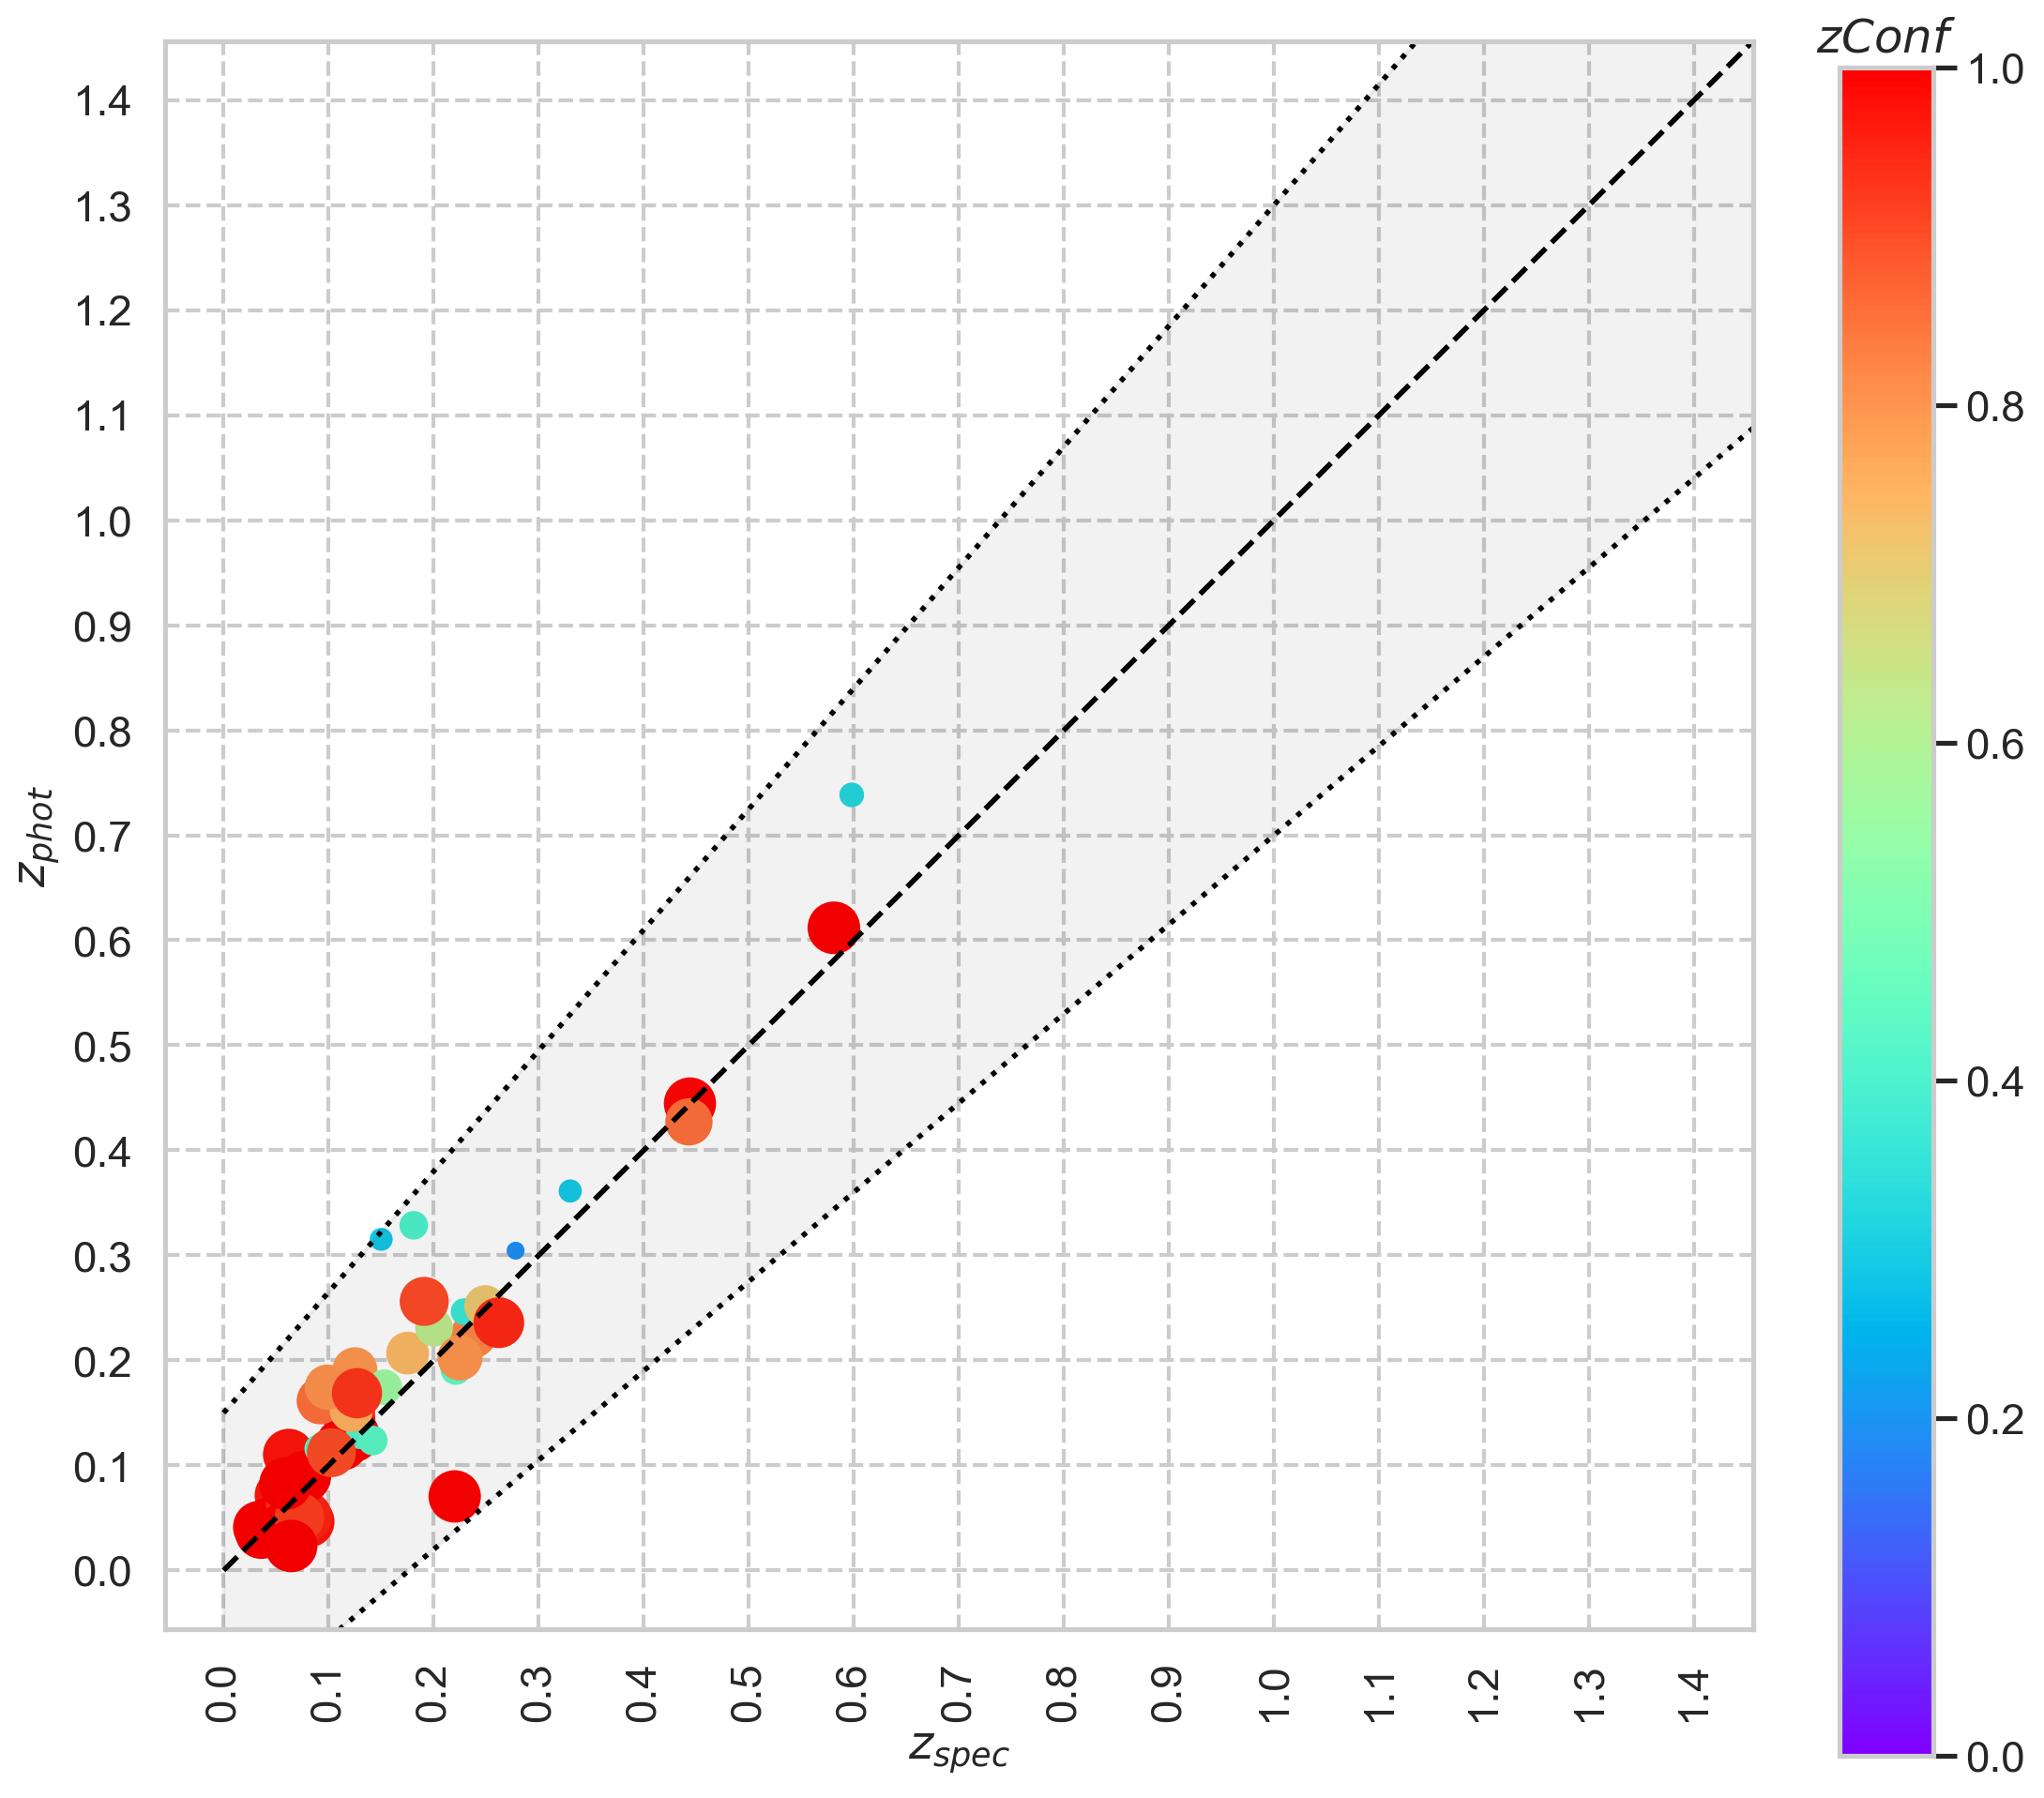

In [8]:
x1a_data_nna = clean_nan(x1a_data, "Redshift_str", "zoo_best-x1a_z_max")
x1a_data_nna = x1a_data_nna.query("Prog in ('TDEs2', 'TDEs4', 'TDEs2r7', 'TDEs5')")
n_predictions, nmad, n015 = calculate_metrics(x1a_data_nna, "Redshift_str", "zoo_best-x1a_z_max")
print(f"N={n_predictions}\tNMAD={nmad:.3f}\tCatastrophic outliers={n015:.3f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set(xlabel='$z_{spec}$', ylabel='$z_{phot}$')

vlim = (0, 1.4)
nticks = 15
scatter_photo_z(x1a_data_nna, "Redshift_str", "zoo_best-x1a_z_max", "zoo_best-x1a_z_maxConf",
                xlim=vlim, xticks=nticks, ylim=vlim, yticks=nticks, figsize_factor=7, ax=ax)

add_colorbar(fig, 0, 1, "$zConf$", "rainbow")

fig.tight_layout()
fig.show()

# Результаы для моделей gal0 (комбинированный прогноз)

N=199	NMAD=0.046	Catastrophic outliers=0.166


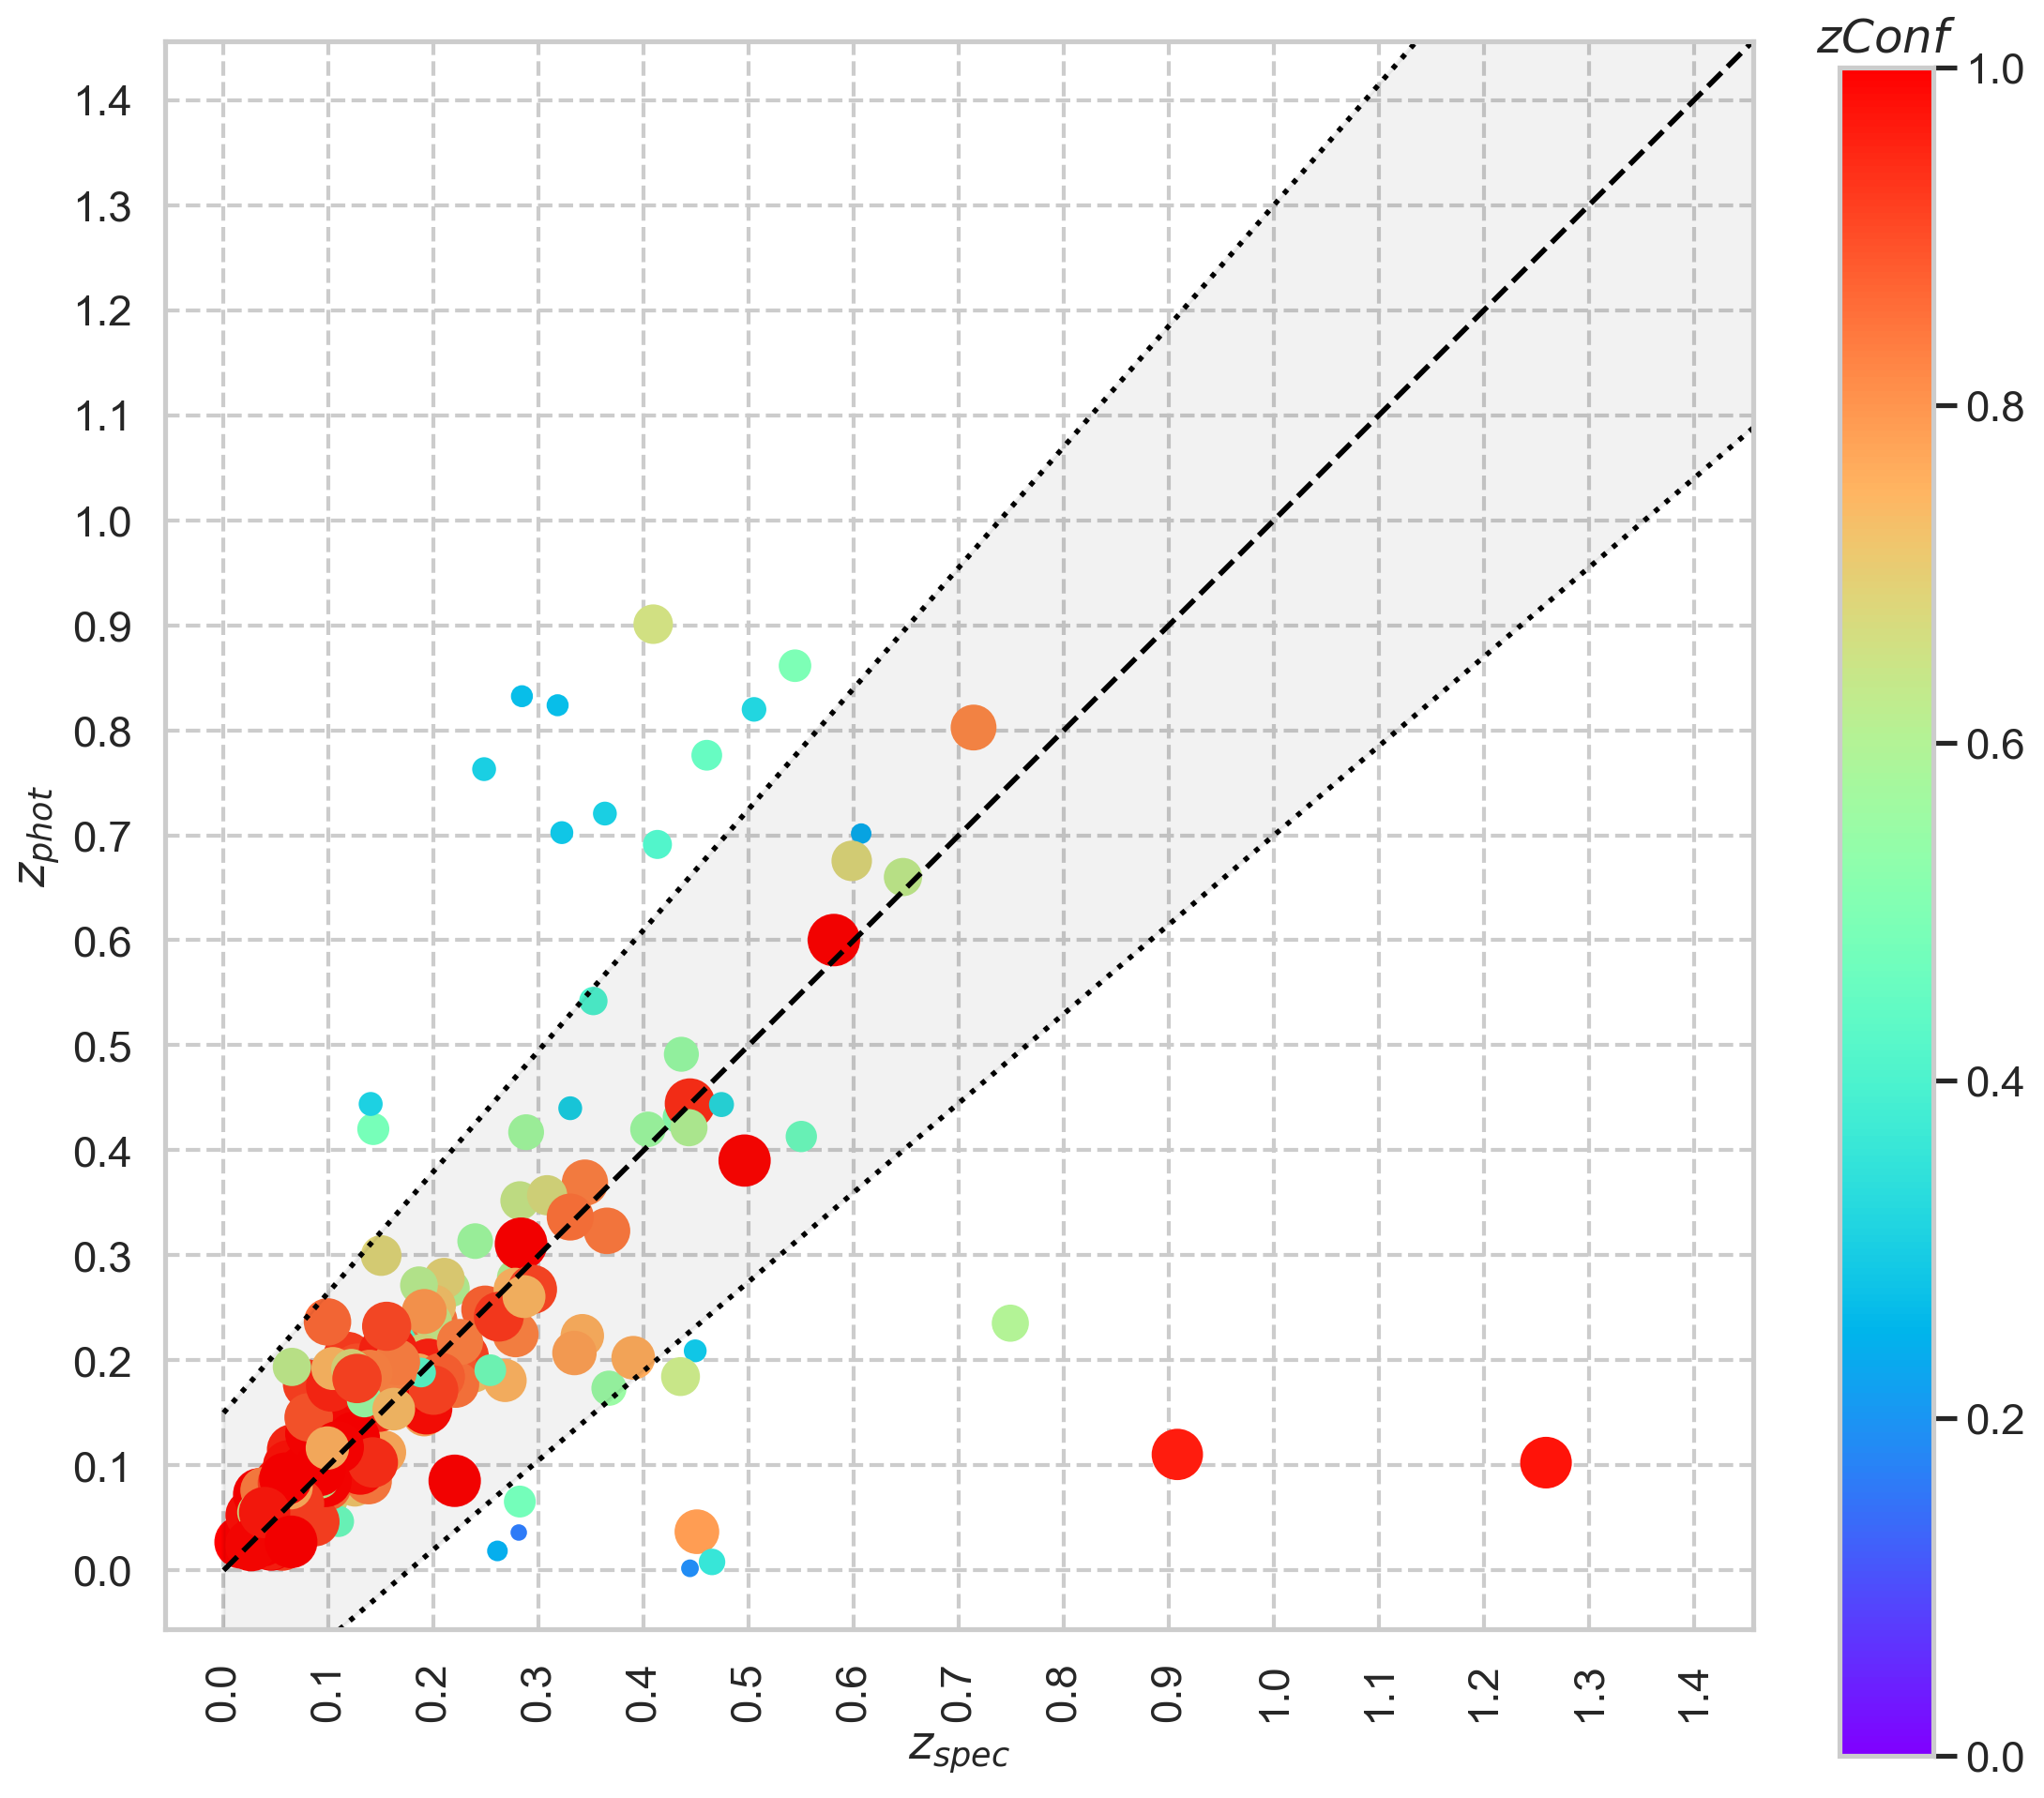

In [6]:
gal0_data_nna = clean_nan(gal0_data, "Redshift_str", "zoo_best-gal0_z_max")
n_predictions, nmad, n015 = calculate_metrics(gal0_data_nna, "Redshift_str", "zoo_best-gal0_z_max")
print(f"N={n_predictions}\tNMAD={nmad:.3f}\tCatastrophic outliers={n015:.3f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set(xlabel='$z_{spec}$', ylabel='$z_{phot}$')

vlim = (0, 1.4)
nticks = 15
scatter_photo_z(gal0_data_nna, "Redshift_str", "zoo_best-gal0_z_max", "zoo_best-gal0_z_maxConf",
                xlim=vlim, xticks=nticks, ylim=vlim, yticks=nticks, figsize_factor=7, ax=ax)

add_colorbar(fig, 0, 1, "$zConf$", "rainbow")

fig.tight_layout()
fig.show()

In [ ]:
for prog_name in (None, 'eXVAR', 'FDS4', 'eXVAGN3', 'TDEs2', 'TDEs4', 'QPE', 'TDEs2r7', 'TDEs5'):
    if prog_name is None:
        prog_query = "Prog in ('eXVAR', 'FDS4', 'eXVAGN3', 'TDEs2', 'TDEs4', 'QPE', 'TDEs2r7', 'TDEs5')"
        chart_name = "All Progs"
    else:
        chart_name = prog_query = f"Prog == '{prog_name}'"

    x1a_data_nna = clean_nan(x1a_data, "Redshift_str", "zoo_best-x1a_z_max").query(prog_query)
    n_predictions, nmad, n015 = calculate_metrics(x1a_data_nna, "Redshift_str", "zoo_best-x1a_z_max")
    metrics_x1a = f"X1A ($N_{{preds}}$={n_predictions}\t$NMAD$={nmad:.3f}\t$n_{{>0.15}}$={n015:.3f})"

    gal0_data_nna = clean_nan(gal0_data, "Redshift_str", "zoo_best-gal0_z_max").query(prog_query)
    n_predictions, nmad, n015 = calculate_metrics(gal0_data_nna, "Redshift_str", "zoo_best-gal0_z_max")
    metrics_gal0 = f"GAL0 ($N_{{preds}}$={n_predictions}\t$NMAD$={nmad:.3f}\t$n_{{>0.15}}$={n015:.3f})"

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle(chart_name)
    ax[0].set(xlabel='$z_{spec}$', ylabel='$z_{phot}$')
    ax[1].set(xlabel='$z_{spec}$', title="gal0")

    vlim = (0, 1.4)
    nticks = 15
    scatter_photo_z(x1a_data_nna, "Redshift_str", "zoo_best-x1a_z_max", "zoo_best-x1a_z_maxConf",
                    xlim=vlim, xticks=nticks, ylim=vlim, yticks=nticks, figsize_factor=7, ax=ax[0])

    scatter_photo_z(gal0_data_nna, "Redshift_str", "zoo_best-gal0_z_max", "zoo_best-gal0_z_maxConf",
                    xlim=vlim, xticks=nticks, ylim=vlim, yticks=nticks, figsize_factor=7, ax=ax[1])

    add_colorbar(fig, 0, 1, "$zConf$", "rainbow")
    ax[0].set_title(metrics_x1a, y=1.01)
    ax[1].set_title(metrics_gal0, y=1.01)

    fig.tight_layout()
    fig.show()

    fig.savefig(IMGS_PATH / f"{chart_name}.png")

In [ ]:
def is_outlier(data: pd.DataFrame, prediction_column: str, true_column: str, threshold=0.15) -> pd.Series:
    dz_norm = (data[prediction_column] - data[true_column]) / (1 - data[true_column])
    return np.abs(dz_norm) >= threshold


x1a_data["x1a_outlier_015"] = is_outlier(x1a_data, "zoo_best-x1a_z_max", "Redshift_str")
gal0_data["gal0_outlier_015"] = is_outlier(x1a_data, "zoo_best-gal0_z_max", "Redshift_str")

columns_to_show = [
    'NAME',
    'RA',
    'Dec',
    'objid',
    't_objid',
    'Prog',
    'P1',
    'zph',"Redshift_str",
    "x1a_outlier_015", "gal0_outlier_015",
    "zoo_best-x1a_z_max", "zoo_best-x1a_z_maxConf",
    "zoo_best-gal0_z_max", "zoo_best-gal0_z_maxConf",
]
outliers_data = x1a_data[x1a_data["x1a_outlier_015"] | gal0_data["gal0_outlier_015"]].loc[:, columns_to_show]

In [ ]:
outliers_data.to_csv(WORKDIR / "outliers_sample.csv")

In [ ]:
x1a_data["sdss_objID"]